In [1]:
from transcription_pipeline import preprocessing_pipeline

dataset_name = "wthbp2-mcpmcherry-bcdgfp-10-31"

# Imports dataset into memory, trimming the last frame of each time-series as requested
dataset = preprocessing_pipeline.DataImport(
    name_folder=dataset_name,
    trim_series=True,
    # import_previous=True,
)

# Saves each channel of the dataset as a zarr, and pickles together dictionaries
# of relevant metadata
dataset.save()

`JAVA_HOME` environment variable set to P:\Yovan\mamba\envs\transcription_pipeline


In [2]:
# Start Dask client for parallelization
from dask.distributed import LocalCluster, Client

cluster = LocalCluster(
    host="localhost",
    scheduler_port=8786,
    threads_per_worker=1,
    n_workers=10,
    memory_limit="10GB",
)

client = Client(cluster)

In [3]:
# Run nuclear segmentation and tracking
from transcription_pipeline import nuclear_pipeline


nuclear_tracking = nuclear_pipeline.Nuclear(
    data=dataset.channels_full_dataset[0],
    global_metadata=dataset.export_global_metadata[0],
    frame_metadata=dataset.export_frame_metadata[0],
    client=client,
    keep_futures=False,
    quantify_nuclear=True,
    division_trigger="nuclear_fluorescence",
)

nuclear_tracking.track_nuclei()

# Saves tracked nuclear mask as a zarr, and pickles dataframes with segmentation and
# tracking information.
nuclear_tracking.save_results(name_folder=dataset_name)

Frame 2: 1 trajectories present.


In [6]:
# Run spot segmentation, filtering and quantification and transfer nuclear labels
# over to corresponding spots.
from transcription_pipeline import spot_pipeline


spot_tracking = spot_pipeline.Spot(
    data=dataset.channels_full_dataset[1],
    global_metadata=dataset.export_global_metadata[1],
    frame_metadata=dataset.export_frame_metadata[1],
    labels=nuclear_tracking.reordered_labels,
    expand_distance=3,
    search_range_um=3.9,
    memory=3,
    min_track_length=2,
    series_splits=dataset.series_splits,
    series_shifts=dataset.series_shifts,
    keep_bandpass=False,
    keep_futures=False,
    keep_spot_labels=False,
    evaluate=True,
    client=client,
)

spot_tracking.extract_spot_traces()


# Saves tracked spot mask as a zarr, and pickles dataframes with spot fitting and
# quantification information.
spot_tracking.save_results(name_folder=dataset_name)

Frame 202: 24 trajectories present.


In [27]:
# Compile input-output data from generated dataframes
from transcription_pipeline.spot_analysis import compile_data


compiled_input_output = compile_data.compile_traces(
    spot_tracking.spot_dataframe,
    nuclear_tracking_dataframe=nuclear_tracking.mitosis_dataframe,
    compile_columns_nuclear=[
        {"t_s": "nuclear_t_s"},
        "nuclear_cycle",
        "nuclear_intensity_mean",
        "nuclear/mnt/Data1/InputOutputMCPHaloTag/P2P(DP)ZldSitesAll/2024-03-07/embryo01_intensity_stdev",
    ],
)

In [28]:
# Restrict to longer traces, filtering stubs. We also restrict to nc14 for now
min_frames = 10
filtered_compiled_input_output = compiled_input_output[
    compiled_input_output["frame"].apply(lambda x: x.size) > min_frames
]

nc = 14
nc_mask = filtered_compiled_input_output.apply(
    lambda x: (x["nuclear_cycle"] == nc).all(), axis=1
)
filtered_compiled_input_output = filtered_compiled_input_output[nc_mask]

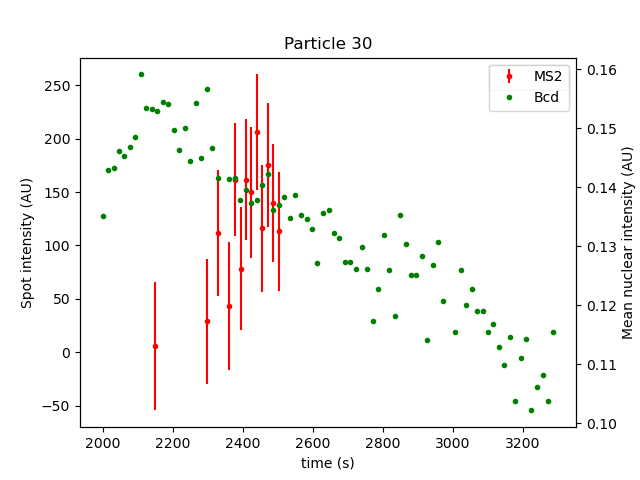

In [29]:
%matplotlib widget
# This is taken from
# https://stackoverflow.com/questions/18390461/scroll-backwards-and-forwards-through-matplotlib-plots
import matplotlib.pyplot as plt


curr_pos = 0


def key_event(e):
    global curr_pos

    if e.key == "right":
        curr_pos = curr_pos + 1
    elif e.key == "left":
        curr_pos = curr_pos - 1
    else:
        return

    curr_pos = curr_pos % len(filtered_compiled_input_output.index)

    t_s = filtered_compiled_input_output.loc[curr_pos, "t_s"]
    intensity_trace = filtered_compiled_input_output.loc[
        curr_pos, "intensity_from_neighborhood"
    ]
    intensity_err = filtered_compiled_input_output.loc[
        curr_pos, "intensity_std_error_from_neighborhood"
    ]

    ax_out.cla()
    ax_out.errorbar(
        t_s, intensity_trace, yerr=intensity_err, fmt=".", color="red", label="MS2"
    )

    ax_out.set_xlabel("time (s)")
    ax_out.set_ylabel("Spot intensity (AU)")
    title = "particle"
    ax_out.set_title(f"Particle {filtered_compiled_input_output.loc[curr_pos, title]}")
    ax_out.legend()

    nuclear_t_s = filtered_compiled_input_output.loc[curr_pos, "nuclear_t_s"]
    nuclear_trace = filtered_compiled_input_output.loc[
        curr_pos, "nuclear_intensity_mean"
    ]
    nuclear_err = filtered_compiled_input_output.loc[
        curr_pos, "nuclear_intensity_stdev"
    ]

    ax_in.cla()
    ax_in.errorbar(
        nuclear_t_s, nuclear_trace, yerr=None, fmt=".", color="green", label="Bcd"
    )

    ax_in.set_ylabel("Mean nuclear intensity (AU)")
    ax_in.yaxis.set_label_position("right")

    fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)

    fig.canvas.draw()


fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event)

ax_out = fig.add_subplot(111)

t_s = filtered_compiled_input_output.loc[curr_pos, "t_s"]
intensity_trace = filtered_compiled_input_output.loc[
    curr_pos, "intensity_from_neighborhood"
]
intensity_err = filtered_compiled_input_output.loc[
    curr_pos, "intensity_std_error_from_neighborhood"
]

ax_out.errorbar(
    t_s, intensity_trace, yerr=intensity_err, fmt=".", color="red", label="MS2"
)

ax_out.set_xlabel("time (s)")
ax_out.set_ylabel("Spot intensity (AU)")
title = "particle"
ax_out.set_title(f"Particle {filtered_compiled_input_output.loc[curr_pos, title]}")
ax_out.legend()

ax_in = ax_out.twinx()

nuclear_t_s = filtered_compiled_input_output.loc[curr_pos, "nuclear_t_s"]
nuclear_trace = filtered_compiled_input_output.loc[curr_pos, "nuclear_intensity_mean"]
nuclear_err = filtered_compiled_input_output.loc[curr_pos, "nuclear_intensity_stdev"]

ax_in.errorbar(
    nuclear_t_s, nuclear_trace, yerr=None, fmt=".", color="green", label="Bcd"
)

ax_in.set_ylabel("Mean nuclear intensity (AU)")


fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax_in.transAxes)


plt.show()